# 🎲 Ludo tracker

## 🗑️ Description 
You should implement a system that recognizes the state of gameplay from the movie (in the selected board game). The program should track the movement of counters, dice, cards and detect events on the film.
The task is also to find the appropriate input data (or your own video recording).

The input data should be divided into 3 groups depending on the difficulty for example:
easy: perfect view, the game elements are not covered with your hands when carrying it...
medium: different dynamics of light in the picture, shadows, light reflections...
difficult: angled view, game components partially covered with hands when moving, slight shaking of the camera...
Each data group should have at least 3 representative clips (max 5 min per clip).

The selected game may be a real board game or some extension of it. It cannot be a computer game, although computer simulations can be used to test solutions or to train ML models.

Typical card games such as poker, macau, bridge … that contain only cards are insufficient and must be extended with some additional elements that should be consulted.
Don’t use NN.


### Requirements
3.0:
* preparation of a data set,
* preparation and presentation of the results (e.g. a game video with information about true events - described below)
* detection of at least 2 elements of the game: counter, dice, card, figure….
tracking some element of game: counters, dices, cards in the movie
* a report containing:
    * Informations from milestone 1,
    * description of the data set, with a few image examples,
    * description of the used techniques along with the intermediate results  for each processing step of the example frame,
    * the effectiveness for each dataset,
    * analysis and conclusions of the obtained results,
    * potential references to literature.

4.0:
* requirements for 3.0 and:
* detection of at least 2 selected events in the movie, e.g.
    * roll the dice and read the result
    * play a card
    * moving a counter(from a given position to a new position)
    * placing a counter

5.0:
* requirements for 4.0 and:
* Game status detection
* detection of at least 5 selected events
* Track gameplay score


## Game description

* team members: Zuzanna Gawrysiak 148255, Agata Żywot 148258
* selected game: Ludo (Chińczyk)
* description: a strategy board game for two to four players, in which the players race their four tokens from start to finish according to the rolls of a single die.
* in-game items:
    * 16 tokens (4 of each colour)
    * 1 dice
    * 1 board
* events:
    * rolling dice (number of dots)
    * moving a token (changing field)
    * winning (four tokens in base)
    * capturing (two tokens of different colours on the same field)
    * enter a token into play from its yard to its starting square (preceded by rolling 6)

## Preparation

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets
import PIL
from PIL import Image
from random import randint
import sys
if '../' not in sys.path:
    sys.path.append('../')

from src.dice import get_dice_number
from src.detection import *
from src.patterns import *
from src.utils import *

%matplotlib inline

# Detection of a board and playing fields

## Detect board

In [2]:
def play_video_board(video_path):
    cap = cv2.VideoCapture(video_path)

    while True:
        success, img = cap.read()
        if not success:
            cap.release()
            break

        ### ALL NECESSARY FUNCTIONS HERE ###
        img, img_coords = detect_board(img)

        ####################################
        cv2.imshow(video_path, img)
        if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
            cap.release()
            break
            
    cv2.destroyAllWindows()

In [23]:
# detect board on video
play_video_board('data/dataset_2/recordings/medium/play_1.mp4')

### Crop the frame

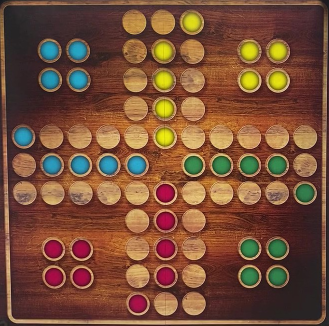

In [3]:
BOARD_IMG_PATH = 'data/dataset_2/board_easy.jpg'
img = cv2.imread(BOARD_IMG_PATH, 1)
board_img, board_coords = detect_board(img)
board_img_cropped = img[board_coords[1]:board_coords[1]+board_coords[3], board_coords[0]:board_coords[0]+board_coords[2]]
imshow(cv2.resize(board_img_cropped, None, fx=0.5, fy=0.5))

## Playing fields detection
Steps:
- image noise reduction
- edge detection
- morphological operations
- contour detection
- check whether rectangles are mostly white/have a certain pattern

In [4]:
def get_playing_fields(image: np.ndarray, rect_size: tuple[int], color: tuple[int] = (0, 0, 255), display_steps: bool = False) -> tuple[np.ndarray, list[int]]:

    tiles_coords = list()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # reduce image noise
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    gray = cv2.medianBlur(gray, 7)

    # detect the edges
    edges = cv2.Canny(gray, 50, 150)

    # morphological operations applied to refine the edges of the fields
    kernel = np.ones((2, 2), np.uint8)
    thresh = cv2.dilate(edges, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    # contour detection
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # draw contours on the original image
    image_res = image.copy()
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if w < rect_size[0] or w > rect_size[1] or h < rect_size[0] or h > rect_size[1] or w/h > 1.4 or h/w > 1.4:
            continue
        cv2.rectangle(image_res, (x, y), (x + w, y + h), color, 2)
        tiles_coords.append(((x, y), (x + w, y + h)))

    if display_steps:
        imshow(np.concatenate([gray, thresh], 1))
        imshow(cv2.resize(image_res, None, fx=0.8, fy=0.8))
    return image_res, tiles_coords

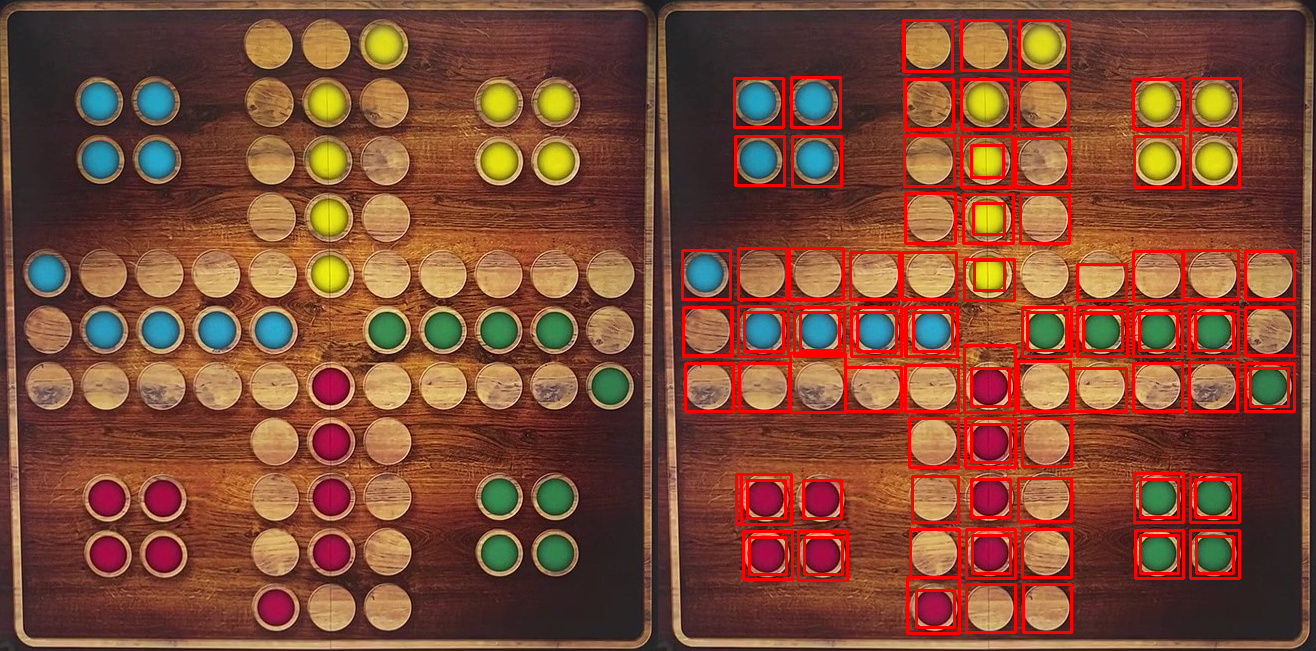

In [16]:
playing_area, fields_coords = get_playing_fields(board_img_cropped, rect_size=(30,100))
imshow(np.concatenate([board_img_cropped, playing_area], 1))

## Counter detection

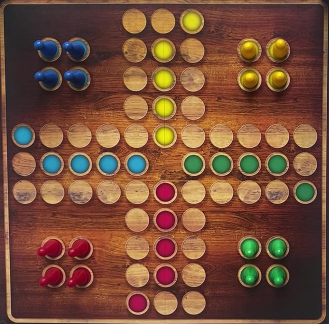

In [47]:
img_bases = cv2.imread('data/dataset_2/all_yard_easy.jpg', 1)
board_img_bases, board2_coords = detect_board(img_bases)
board_img_bases_cropped = img_bases[board2_coords[1]:board2_coords[1]+board2_coords[3], board2_coords[0]:board2_coords[0]+board2_coords[2]]
imshow(cv2.resize(board_img_bases_cropped, None, fx=0.5, fy=0.5))

### Creating masks

In [48]:
mask_img_list = list()
mask = np.zeros_like(board_img_cropped)
for p1, p2 in fields_coords:
    temp_mask = mask.copy()
    cv2.rectangle(temp_mask, (p1[0], p1[1]), (p2[0], p2[1]), (255, 255, 255), -1)

    # apply mask
    masked_image = cv2.bitwise_and(board_img_cropped, temp_mask)
    mask_img_list.append(masked_image)

# for m in mask_img_list[:3]:
#     imshow(cv2.resize(m, None, fx=0.5, fy=0.5))

In [57]:
# len(mask_img_list)

In [49]:
resized_img = cv2.resize(board_img_bases_cropped, (board_img_cropped.shape[1], board_img_cropped.shape[0]), interpolation=cv2.INTER_LINEAR)
assert board_img_cropped.shape == resized_img.shape

### Taking the difference

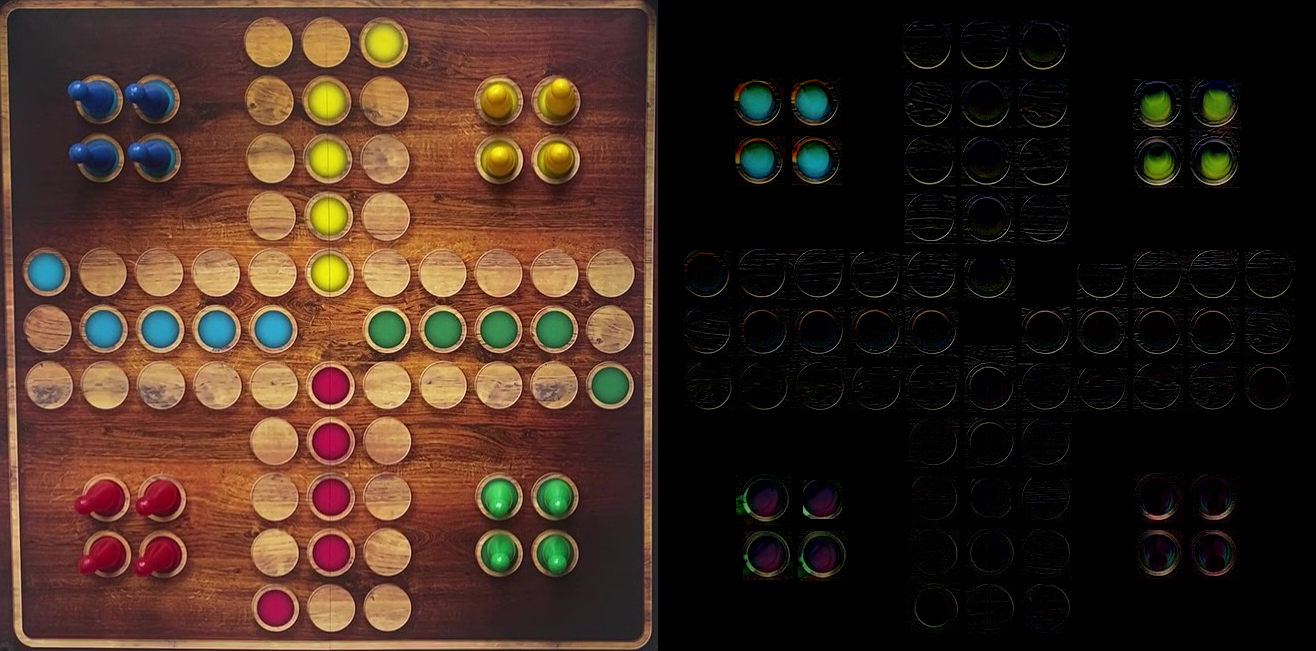

In [50]:
counters_img = np.zeros_like(board_img_cropped)
counters_img_bin = np.zeros_like(cv2.cvtColor(board_img_cropped, cv2.COLOR_BGR2GRAY))
for m in mask_img_list:
   subtracted = cv2.subtract(m, resized_img)
   subtracted_gray = cv2.cvtColor(subtracted, cv2.COLOR_BGR2GRAY)
   _, bin_mask = cv2.threshold(subtracted_gray, 60, 255, cv2.THRESH_BINARY)
   counters_img = cv2.bitwise_or(counters_img, subtracted)
   counters_img_bin = cv2.bitwise_or(counters_img_bin, bin_mask)
   
   # subtracted2 = cv2.subtract(resized_img, m)
imshow(np.concatenate([resized_img, counters_img], 1)) 

### Find areas of interest

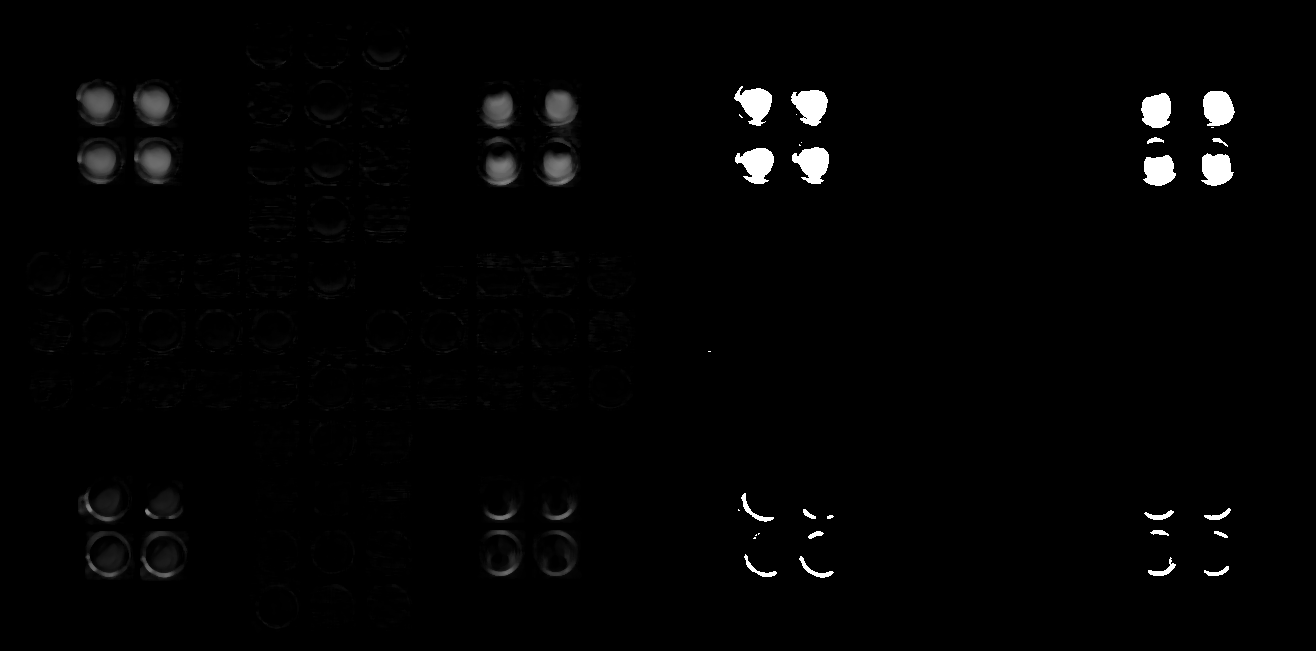

In [54]:
frame = counters_img.copy()
frame = cv2.medianBlur(frame, 5)
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
_, bin_mask = cv2.threshold(frame_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow(np.concatenate([frame_gray, bin_mask], 1))

In [ ]:
# TODO
# select the boxes (found earlier) that have the highest % of white wrt the above img -> counter areas
# determine their color
# put the pipeline above into funtions
# next step: counting points

### Check counter color

In [38]:
import cv2

# Load the input image
input_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

# Define the coordinates of the rectangles
rectangles = [(100, 100, 200, 200), (150, 150, 250, 250)]

# Create a black image with the same size as the input image
mask = np.zeros_like(input_image)

# Draw the rectangles on the mask
for x, y, w, h in rectangles:
    cv2.rectangle(mask, (x, y), (x+w, y+h), (255, 255, 255), -1)

# Combine the rectangles into a single image
combined = cv2.bitwise_or(input_image, mask)

# Find the contours in the combined image
contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select the contour with the largest area
largest_contour = max(contours, key=cv2.contourArea)

# Draw the largest contour on the input image
cv2.drawContours(input_image, [largest_contour], -1, (255, 0, 0), 3)

# Display the image
cv2.imshow('Playing fields', input_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### TRASH

In [106]:
def detect_colors(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # BLUE MASK
    lower_bound = (85, 100, 100)
    upper_bound = (140, 255, 255)
    mask_blue = cv2.inRange(image_hsv, lower_bound, upper_bound)
    
    # GREEN MASK
    lower_bound = (40, 100, 100)
    upper_bound = (80, 255, 255)
    mask_green = cv2.inRange(image_hsv, lower_bound, upper_bound)

    # YELLOW MASK
    lower_bound = (20, 100, 100)
    upper_bound = (30, 255, 200)
    mask_yellow = cv2.inRange(image_hsv, lower_bound, upper_bound)
    
    # RED MASK
    lower_bound = (150, 100, 100)
    upper_bound = (179, 255, 255)
    mask_red = cv2.inRange(image_hsv, lower_bound, upper_bound)

    combined_mask = cv2.bitwise_or(mask_blue, mask_green)
    combined_mask = cv2.bitwise_or(combined_mask, mask_yellow)
    combined_mask = cv2.bitwise_or(combined_mask, mask_red)

    masked_image = cv2.bitwise_and(image, image, mask=combined_mask)
    return masked_image

In [25]:
color_image = detect_colors(board_img_cropped)
cv2_imshow('Image', color_image)

In [155]:
import cv2

# Load the input image and the reference image
input_image = cv2.imread('data/dataset_2/board_easy.jpg', 1)
reference_image = board_img_cropped

# Convert the images to grayscale
input_image_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
reference_image_gray = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)

# Create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Detect points in the input image
keypoints_input, descriptors_input = sift.detectAndCompute(input_image_gray, None)

# Detect points in the reference image
keypoints_reference, descriptors_reference = sift.detectAndCompute(reference_image_gray, None)

# Create a brute-force matcher object
bf = cv2.BFMatcher()

# Match the descriptors
matches = bf.match(descriptors_input, descriptors_reference)

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw the matches
img_matches = cv2.drawMatches(input_image, keypoints_input, reference_image, keypoints_reference, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the image
cv2.imshow('Image', img_matches)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
BOARD_IMG_PATH = 'data/dataset_2/board_easy.jpg'
from sklearn.cluster import KMeans
import plotly.graph_objects as go

In [13]:
board_img = cv2.imread(BOARD_IMG_PATH, 1)
# imshow(cv2.resize(board_img, None, fx=0.5, fy=0.5))

In [14]:
def pix_show(pixels, skip_each=1, height=800, width=800, colors=None):
  pixels = pixels[::skip_each]
  if colors is None: colors = pixels[:, ::-1]
  else: colors = colors[::skip_each]
  b, g, r = pixels[:, 0], pixels[:, 1], pixels[:, 2]
  fig = go.Figure(data=[
    go.Scatter3d(x=b, y=g, z=r, mode='markers', marker={
        'size': 2,
        'color': colors,
        'opacity': 0.7
    })
  ], layout_xaxis_range=[0, 1], layout_yaxis_range=[0, 1])
  scene = {
      'xaxis': dict(title='Blue'),
      'yaxis': dict(title='Green'),
      'zaxis': dict(title='Red')
  }
  fig.update_layout(autosize=False, height=height, width=width, scene=scene, showlegend=True)
  fig.show()

In [15]:
img_pixels = board_img.reshape([-1, 3])
# pix_show(img_pixels, 16, height=500, width=500)

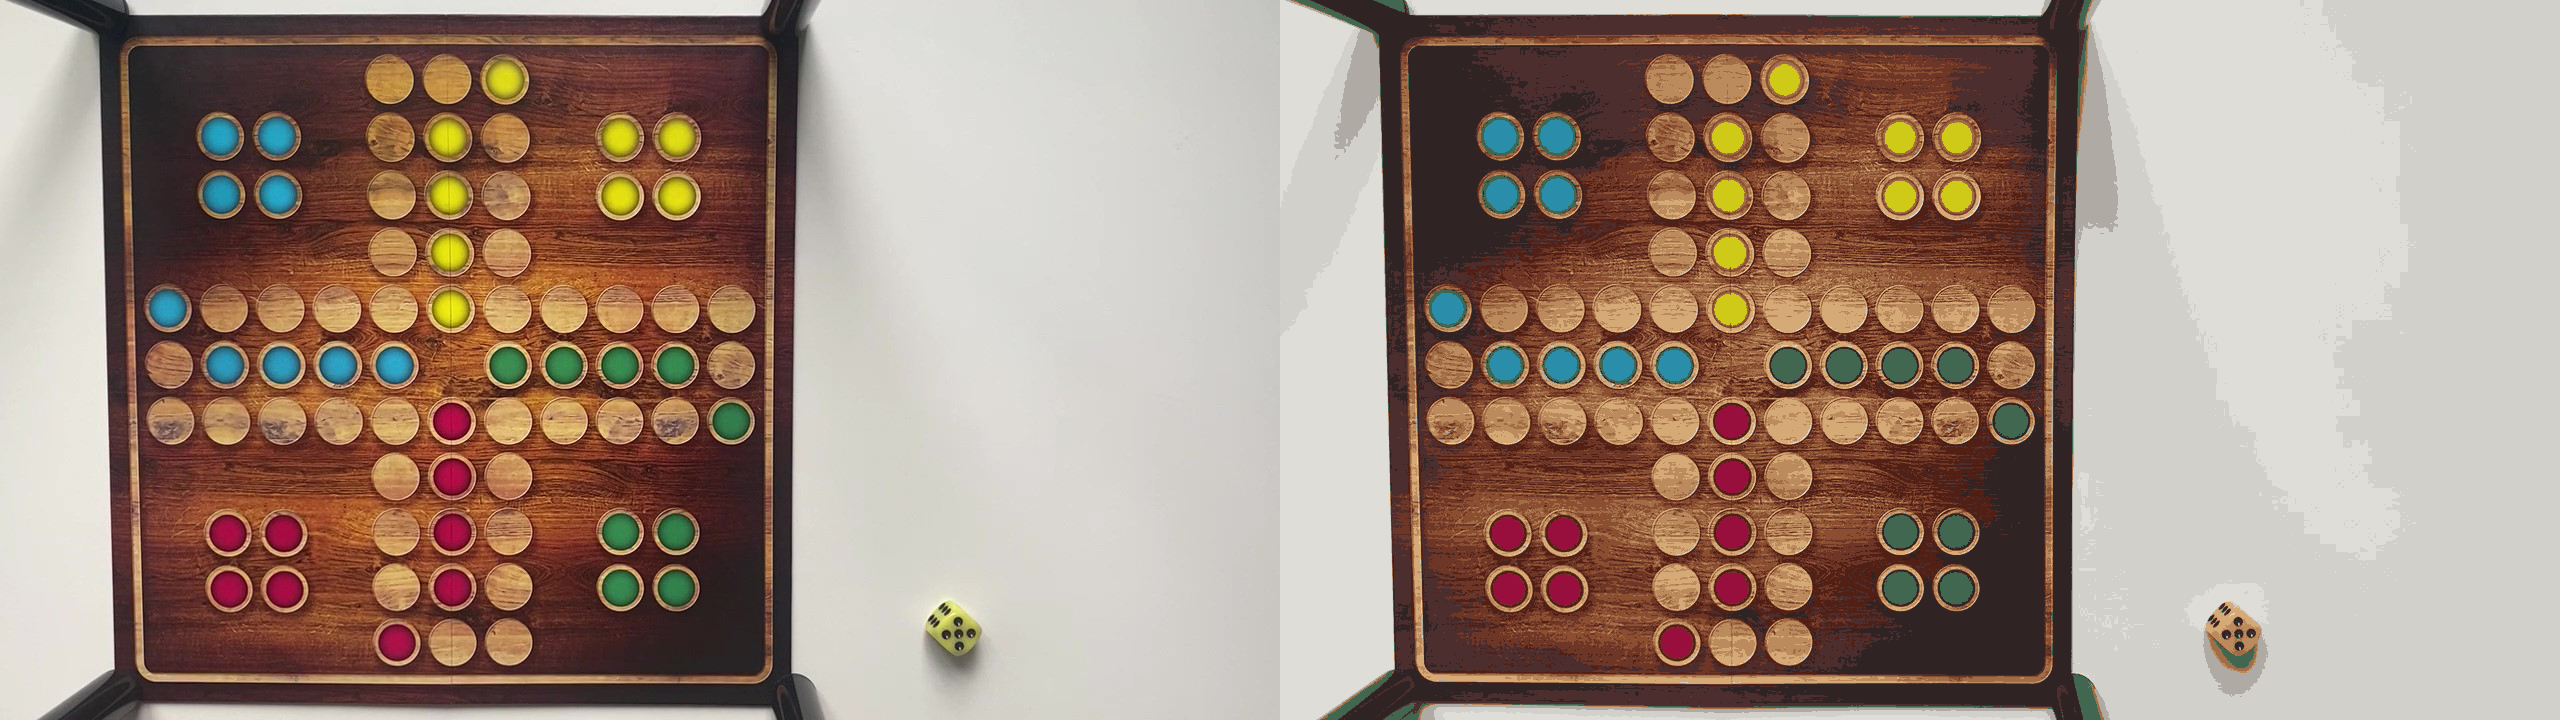

In [16]:
N = 15
model = KMeans(n_clusters=N)
model.fit(img_pixels)
segments = model.predict(img_pixels)

segments_colors = np.stack([img_pixels[segments==i].mean(0) for i in range(N)], 0)
colors = np.take(segments_colors, segments, 0)

# pix_show(img_pixels, 16, colors=colors[:, ::-1])
segmented = colors.reshape(board_img.shape)
imshow(np.concatenate([board_img, segmented], 1))

In [21]:
segmented2 = segmented.astype('uint8')

print(segmented.shape, segmented.dtype)
print(board_img.shape, board_img.dtype)
print(segmented2.shape, segmented2.dtype)

(720, 1280, 3) float64
(720, 1280, 3) uint8
(720, 1280, 3) uint8


In [22]:
cv2_imshow('segmented', segmented2)

## Recognizing states
1. Map board: coordinates of every element

    - dice (done) **ZUZA DONE**
    - starting area (pattern) **ZUZA DONE**
    - yards (pattern) **ZUZA DONE**
    - playing area (each box) **AGATA DONE**
    - bases (color box -> get colors) **AGATA**
    - counter detection (circles in specified color) - **AGATA**


### Dice rolling
Blob detection -> clustering (DBSCAN).

In [3]:
TEMPLATES_PATH_DIR = 'data/dataset_1/templates'
BOARD_IMG_PATH = 'data/dataset_2/board_easy.jpg'
COLORS = [(0,0,255), (255,0,0), (0,255,0), (255,0,255)]

In [4]:
cap = cv2.VideoCapture('data/recordings/easy/play_1.MOV')
# Video.from_file('data/full_dice.mp4')

In [5]:
# works kinda laggy but for now it may be helpful to see the results online
vid = cv2.VideoCapture('data/recordings/easy/play_1.MOV')
try:
    while(True):
        ret, frame = vid.read()
        if not ret:
            vid.release()
            break
        frame = get_dice_number(frame[:,:370])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.axis('off')
        plt.imshow(frame)
        plt.show()
        clear_output(wait=True)
except KeyboardInterrupt:
    vid.release()
    print("Released Video Resource")

Released Video Resource


### Ludo board

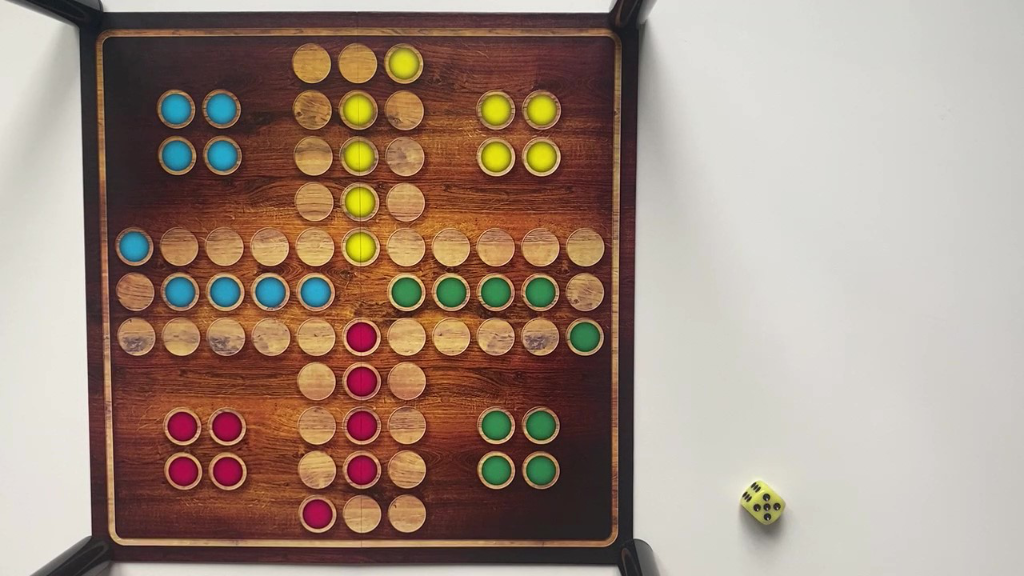

In [6]:
board_clear = cv2.imread(BOARD_IMG_PATH, 1)
imshow(cv2.resize(board_clear, None, fx=0.8, fy=0.8))

### Start field, yards and bases
Detected using template matching opencv method.

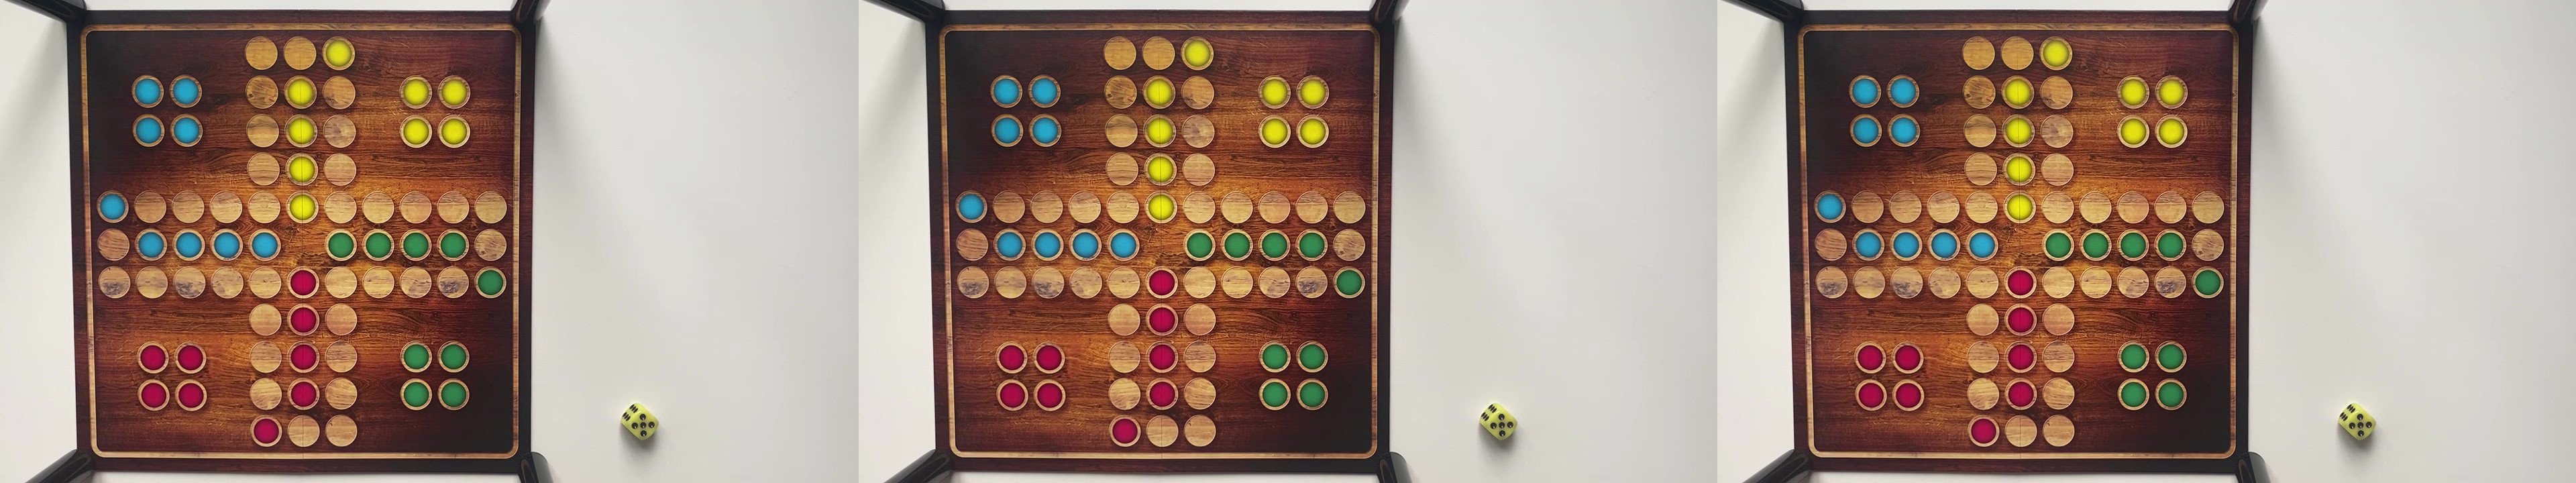

In [7]:
start_templates = ["start_blue", "start_green", "start_red", "start_yellow"]
start_templates_files = [f'{TEMPLATES_PATH_DIR}/{t}.jpg' for t in start_templates]
starts, start_coords = match_patterns(board_clear, start_templates_files, color=COLORS[1])
# imshow(cv2.resize(starts, None, fx=0.8, fy=0.8))

yard_templates = ["yard_blue", "yard_green", "yard_red", "yard_yellow"]
yard_templates_files = [f'{TEMPLATES_PATH_DIR}/{t}.jpg' for t in yard_templates]
yards, yards_coords = match_patterns(board_clear, yard_templates_files, color=COLORS[2])
# imshow(cv2.resize(yards, None, fx=0.8, fy=0.8))

base_templates = ["base_blue", "base_green", "base_red", "base_yellow"]
base_templates_files = [f'{TEMPLATES_PATH_DIR}/{t}.jpg' for t in base_templates]
bases, bases_coords = match_patterns(board_clear, base_templates_files, color=COLORS[3])
# imshow(cv2.resize(bases, None, fx=0.8, fy=0.8))

imshow(np.concatenate([starts, yards, bases], 1))

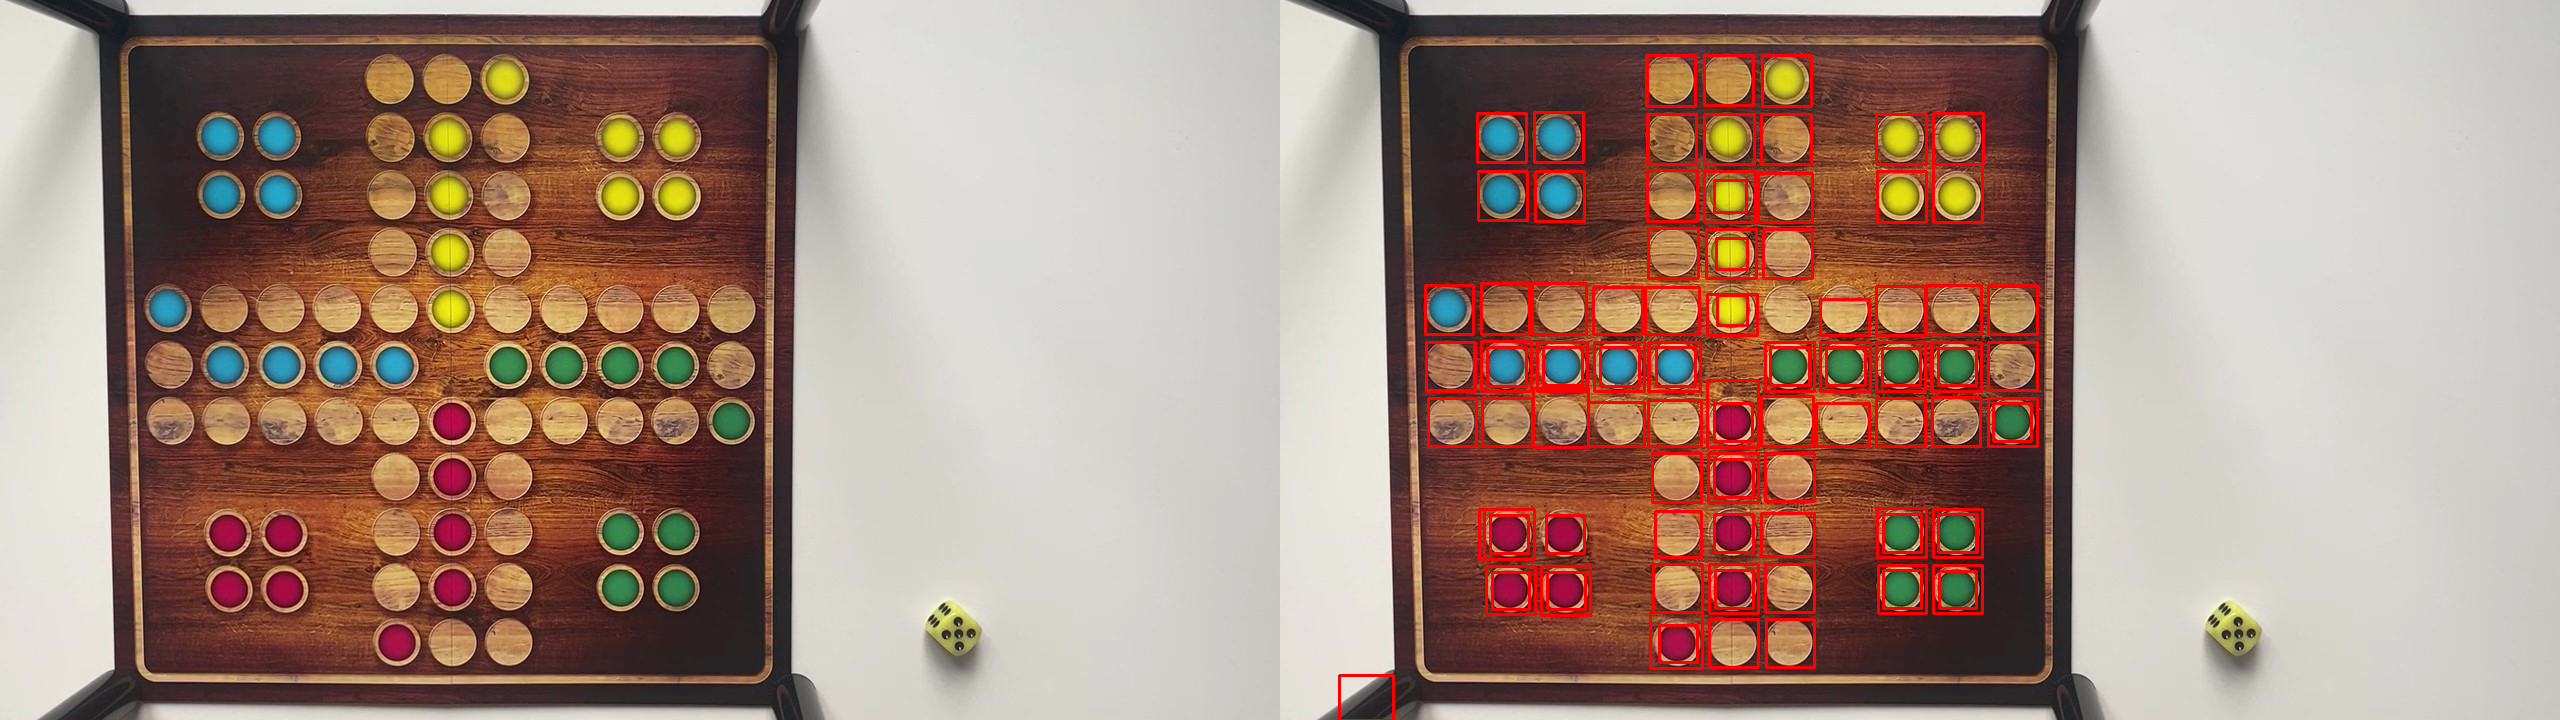

In [10]:
board_clear_with_objects = board_clear.copy() 
coords = [ tiles_coords,start_coords, yards_coords, bases_coords]
for coord_type, color in zip(coords, COLORS):
    for c in coord_type:
        cv2.rectangle(board_clear_with_objects, c[0], c[1], color, 2)
imshow(np.concatenate([board_clear, board_clear_with_objects],1))
# imshow(board_clear_with_objects)

Released Video Resource


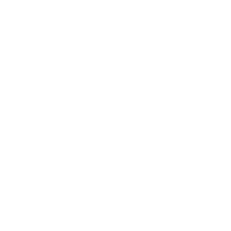

In [11]:
vid = cv2.VideoCapture('data/dataset_1/recordings/easy/game_state_1.mov')
OUTPUT_FILENAME = 'test.mov'

try:
    while(True):
        ret, frame = vid.read()
        if not ret:
            vid.release()
            break
        for coord_type, color in zip(coords, COLORS):
            for c in coord_type:
                cv2.rectangle(frame, c[0], c[1], color, 2)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.axis('off')
        plt.imshow(frame)
        plt.show()
        clear_output(wait=True)
except KeyboardInterrupt:
    vid.release()
    print("Released Video Resource")

### Counter detection
- based on tile coordinates detected at the beginning -> **TODO**

In [12]:
cap = cv2.VideoCapture('data/recordings/easy/play_1.MOV')
success, frame = cap.read()

In [14]:
yard_templates = ["counter_blue", "counter_green", "counter_red2", "counter_yellow"]
yard_templates_files = [f'data/templates/{t}.png' for t in yard_templates]
yards, yards_coords = match_patterns(frame, yard_templates_files, color=COLORS[2], threshold=0.8)
imshow(yards)

In [ ]:
len(yards_coords)

## Tracking

### Counter tracking

In [ ]:
cap = cv2.VideoCapture('data/recordings/easy/play_1.MOV')
success, frame = cap.read()
if not success:
  print('Failed to read video')
  sys.exit(1)

In [ ]:
bboxes = []
colors = [] 
 
# OpenCV's selectROI function doesn't work for selecting multiple objects in Python
# So we will call this function in a loop till we are done selecting all objects
while True:
  # draw bounding boxes over objects
  # selectROI's default behaviour is to draw box starting from the center
  # when fromCenter is set to false, you can draw box starting from top left corner
  bbox = cv2.selectROI('MultiTracker', frame)
  bboxes.append(bbox)
  colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))
  print("Press q to quit selecting boxes and start tracking")
  print("Press any other key to select next object")
  k = cv2.waitKey(0) & 0xFF
  if (k == 113):  # q is pressed
    break
 
print('Selected bounding boxes {}'.format(bboxes))

In [ ]:
# not to use roi everytime
bboxes = [(705, 602, 34, 34), (1003, 449, 35, 28), (448, 214, 34, 36)]
colors = [(0,0,255), (255,0,0), (0,255,0)]

In [ ]:
multiTracker = cv2.legacy.MultiTracker.create()

for bbox in bboxes:
    multiTracker.add(cv2.legacy.TrackerCSRT_create(), frame, bbox)

In [ ]:
# Process video and track objects
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # get updated location of objects in subsequent frames
    success, boxes = multiTracker.update(frame)

    # draw tracked objects
    for i, newbox in enumerate(boxes):
        p1 = (int(newbox[0]), int(newbox[1]))
        p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
        cv2.rectangle(frame, p1, p2, colors[i], 2, 1)

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # show frame
    plt.axis('off')
    plt.imshow(frame)
    plt.show()
    clear_output(wait=True)

    # quit on esc button
    if cv2.waitKey(1) & 0xFF == 27:  # esc pressed
        break
